# Re-Inventing QFT

**Prerequisites**

You need to have Qiskit installed (for vizualizations only)

Also, install Quantastica QPS API by uncommenting this line:

In [16]:
# !pip install quantastica-qps-api

Fore details see: https://pypi.org/project/quantastica-qps-api/

**You need to run following only once on this system** and then remove the cell - don't keep your API key in notebook.

Uncomment following two lines, add your API key and run:

In [17]:
# from quantastica.qps_api import QPS

# QPS.save_account("YOUR_API_TOKEN")

First, we classically generate input and output data encoded into state vectors:

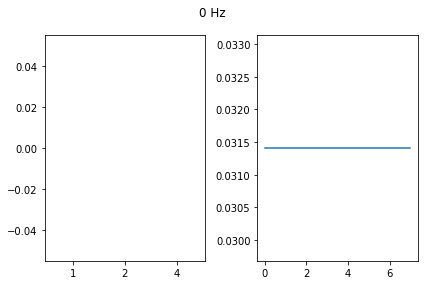

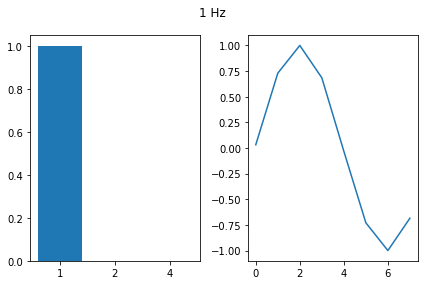

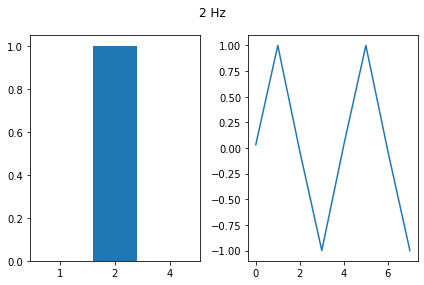

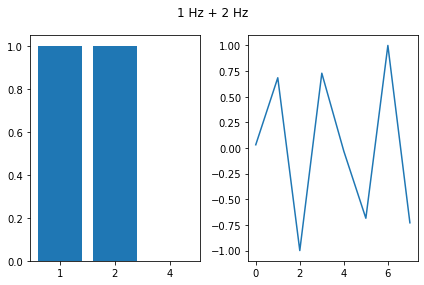

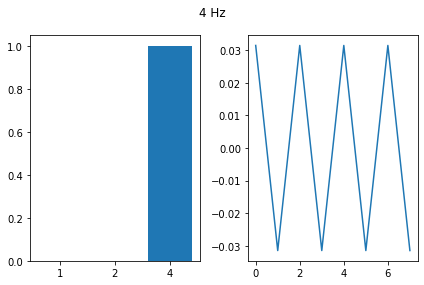

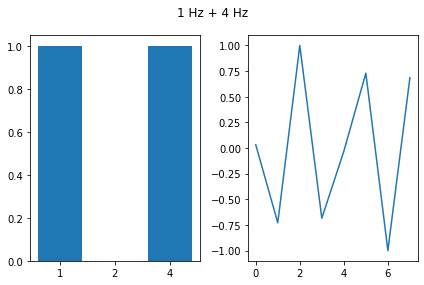

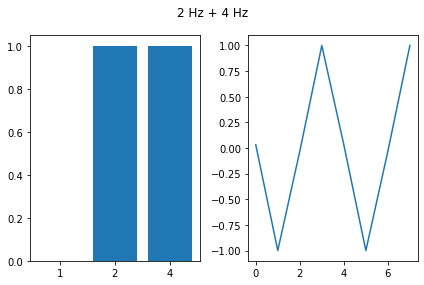

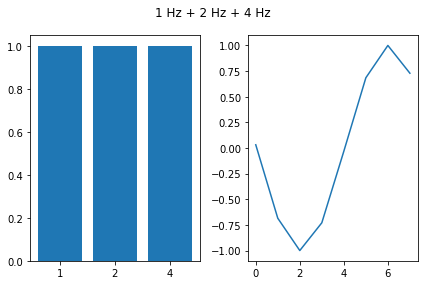

In [18]:
import numpy as np
import cmath
from matplotlib import pyplot as plt

def signal_to_vector(freq, num_qubits):
    r = np.sqrt(1 / (2**num_qubits))
    angles = np.linspace(0, 2*np.pi * freq, 2**num_qubits, endpoint=False)
    return [np.round(cmath.rect(r, angle), 7) for angle in angles]


def multiply_values(c1, c2):
    n1 = cmath.rect(1, np.angle(c1))
    n2 = cmath.rect(1, np.angle(c2))
    r = (np.abs(c1) + np.abs(c2)) / 2
    angle = np.angle(n1 * n2)
    res = cmath.rect(r, angle)
    return res


def multiply_vectors(v1, v2):
    return list(map(lambda x, y: multiply_values(x, y), v1, v2))


def mix_vectors(vectors):
    mixed = vectors[0]
    for i in range(1, len(vectors)):
        mixed = multiply_vectors(mixed, vectors[i])

    return mixed


def generate_vector(freq_sum, num_qubits):
    if(freq_sum == 0):
        return np.full(2**num_qubits, np.sqrt(1 / (2**num_qubits)), dtype=complex)

    vectors = []
    for qubit in range(num_qubits):
        frequency = 2**qubit
        if(freq_sum & frequency):
            vectors.append(signal_to_vector(frequency, num_qubits))
    
    return mix_vectors(vectors)


def generate_vector_pair(freq_sum, num_qubits):
    output_vector = list(generate_vector(freq_sum, num_qubits))

    input_vector = list(np.zeros(2**num_qubits))
    input_vector[freq_sum] = 1

    return [input_vector, output_vector]
   

def int_to_bin_list(n, num_bits):
    fmt = "0" + str(num_bits) + "b"
    s = format(n, fmt)
    numbers = [int(s[i:i+1], 2) for i in range(0, len(s), 1)]
    return numbers[::-1]


def plot_vector_pair(vector_pair):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    num_qubits = int(np.log2(len(vector_pair[0])))
    frequency = vector_pair[0].index(1)
    bin_list = int_to_bin_list(frequency, num_qubits)
    frequencies = []
    for bit_index in range(len(bin_list)):
        if(bin_list[bit_index] == 1):
            frequencies.append(2**bit_index)
    s = ""
    if(len(frequencies) == 0):
        s = s + "0 Hz"
    else:
        for f in frequencies:
            if(s != ""):
                s = s + " + "
            s = s + str(f) + " Hz"
            
    bin_scale = []
    for bit_index in range(num_qubits):
        bin_scale.append(str(2**bit_index))
    
    fig.suptitle(s)
    ax1.bar(bin_scale, bin_list)
    ax2.plot(range(len(vector_pair[1])), np.round(np.sin(np.angle(vector_pair[1]) + np.pi/100), 5))
    fig.tight_layout()
    plt.show()

    
def plot_vector_pairs(vector_pairs):
    for vector_pair in vector_pairs:
        plot_vector_pair(vector_pair)

    
def generate_vector_pairs(num_qubits):
    vector_pairs = []
    for freq_sum in range(2**num_qubits):
        vector_pair = generate_vector_pair(freq_sum, num_qubits)
        vector_pairs.append(vector_pair)
        
    return vector_pairs


# Classically generate example input and output vectors

NUM_QUBITS = 3
   
vector_pairs = generate_vector_pairs(NUM_QUBITS)

plot_vector_pairs(vector_pairs)


Now, when we have pairs of input and output vectors, we reverse-engineer quantum circuit:

Running...

Output:

OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
h q[0];
h q[2];
h q[0];
cu1 (1.570796326795892) q[1], q[2];
h q[1];
swap q[0], q[2];
cu1 (0.785398163397931) q[0], q[2];
cu1 (1.570796326793819) q[1], q[2];
h q[2];



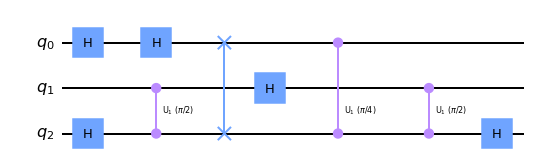

In [19]:
from quantastica.qps_api import QPS
from qiskit import QuantumCircuit


def circuit_from_vector_pairs(vector_pairs, generator_settings):
    print("Running...\n")

    job_id = QPS.generator.circuit_from_vectors(vector_pairs, settings = generator_settings)

    job = QPS.generator.get_job(job_id, wait=True)

    job_status = job["status"]
    job_output = job["output"]

    if(job_status == "error"):
        raise Exception(job_output["message"])
    else:
        for circuit in job_output["circuits"]:
            qasm = circuit["qasm"]
            print("Output:\n")
            print(qasm)
            qc = QuantumCircuit.from_qasm_str(qasm)
            display(qc.draw(output="mpl"))

#
# Reverse-engineer circuit from vectors
#
# This method is slow for more than 3 qubits, but returns optimal solution:
#
circuit_from_vector_pairs(vector_pairs, generator_settings = { "single_solution": True, "pre_processing": "experimental1", "instruction_set": ["h", "cu1", "swap"] })

#
# For more than 3 qubits please use following settings:
#
# circuit_from_vector_pairs(vector_pairs, generator_settings = { "single_solution": True, "strategy": "strategy_b" })
#
# This strategy will return deeper circuit (with u3,cx instruction set) which can be transpiled/optimmized later



Resulting circuit is QFT.

Note that gates in the resulting circuit are arranged differently than what you can usually see in textbooks (swap gates are usually at the end of the circuit etc.), but circuit is perfectly valid QFT. 